<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/Inicio_PINN_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

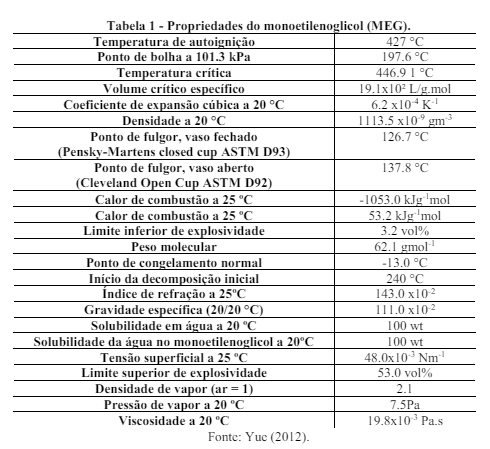

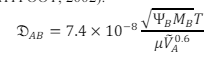

In [63]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam, SGD, Adagrad, AdamW, RMSprop, Adadelta
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image, HTML

In [64]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
np.random.seed(0)

In [65]:
#Definindo os pontos X
N_0 = 200 #200 pontos para condição inicial
N_bx = 200 #200 pontos para condição de contorno em x
N_by = 200 #200 pontos para a condição de contorno em y
N_r = 20000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 600. #Tempo de simulação
xmin = 0.; xmax = 10. #largura do duto
ymin = 0.; ymax = 0.12 #Diametro


#Constantes
T = 352.89 #K
v = 2.21 #m/s
phimeg = 50. #parametro do solvente
Mmeg = 10. #Peso molecular do meg, em g/mol
mi = 7.84 #Viscosidade da solução, centipoises
Va = 0.1130 #Volume molar do soluto, em cm³/g*mol
Difu = 7.4e-8 *((np.sqrt(phimeg*Mmeg)*T)/(mi*Va**0.6))
#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

In [66]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(3))
  #Escala de entrada, mapeando os pontos de maximo e minimo

  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal())) #camada oculta

  modelo.add(Dense(1)) #camada de saída
  modelo.summary()
  return modelo

In [67]:
modelo = modelopinn(30,8)

otimizador = Adam(learning_rate = 0.005)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 3)                 0         
                                                                 
 dense_18 (Dense)            (None, 30)                120       
                                                                 
 dense_19 (Dense)            (None, 30)                930       
                                                                 
 dense_20 (Dense)            (None, 30)                930       
                                                                 
 dense_21 (Dense)            (None, 30)                930       
                                                                 
 dense_22 (Dense)            (None, 30)                930       
                                                                 
 dense_23 (Dense)            (None, 30)               

In [68]:
def c_contorno(t, x, y):
  return tf.where(tf.equal(x, tf.reduce_max(x)), 1.0 * tf.ones_like(x), tf.zeros_like(x))
  #return tf.ones_like(x)

def c_inicial(x, y):
  return tf.zeros_like(x)

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin, ymin]); ub = tf.constant([tmax, xmax, ymax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de 0 a 2
y0 = tf.random.uniform((N_0, 1), lb[2], ub[2])
espaco0 = tf.concat([t0, x0, y0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0
#Condição inicial
c0 = c_inicial(x0,y0)

#Repetindo o processo, mas para a condição de contorno
tbx = tf.random.uniform((N_by,1), lb[0], ub[0])
xbx = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_by,1), 0.5)
ybx = tf.random.uniform((N_by,1), lb[2], ub[2])
espacobx = tf.concat([tbx, xbx, ybx], 1)
c_contx = c_contorno(tbx,xbx,ybx)

tby1 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby1 = tf.random.uniform((N_by,1), lb[1], ub[1])
yby1 = tf.zeros((N_bx,1))
espacoby1 = tf.concat([tby1, xby1, yby1], 1)

tby2 = tf.random.uniform((N_by,1), lb[0], ub[0])
xby2 = tf.random.uniform((N_by,1), lb[1], ub[1])
yby2 = tf.ones((N_bx,1))*ub[2]
espacoby2 = tf.concat([tby2, xby2, yby2], 1)
#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
yr = tf.random.uniform((N_r,1), lb[2], ub[2])
espacor = tf.concat([tr, xr,yr], 1)

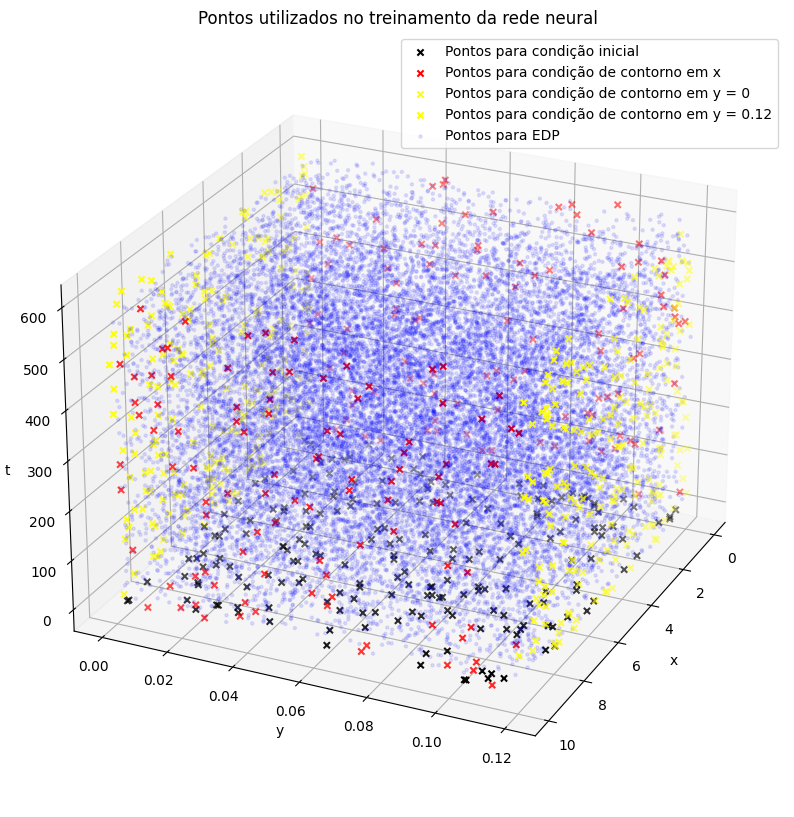

In [69]:
# Plotar os pontos que serão utilizados
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x0,y0,t0, c = 'black', marker ='x', label = 'Pontos para condição inicial')
ax.scatter(xbx,ybx,tbx, c = 'red', marker = 'x', label = 'Pontos para condição de contorno em x')
ax.scatter(xby1,yby1,tby1, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0')
ax.scatter(xby2,yby2,tby2, c = 'yellow', marker = 'x', label = 'Pontos para condição de contorno em y = 0.12')
ax.scatter(xr,yr,tr, c = 'blue', marker = '.', alpha = 0.1, label = 'Pontos para EDP')
ax.view_init(25,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.legend()
ax.set_title('Pontos utilizados no treinamento da rede neural');
plt.show()

In [70]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    t, x, y = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]
    tape.watch(t)
    tape.watch(x)
    tape.watch(y)

    #previsão do modelo
    u = modelo(tf.concat([t, x, y], axis = 1))

    #Derivadas de primeira ordem
    u_x = tape.gradient(u, x)
    u_y = tape.gradient(u, y)
    u_t = tape.gradient(u,t )

    #Derivadas de segunda ordem
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    f = u_t + v*(u_x + u_y) - Difu*(u_xx + u_yy)

  del tape

  return f


def neumanncondy2(modelo, espacoby2):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty2, xy2, yy2 = espacoby2[:, 0:1], espacoby2[:,1:2], espacoby2[:,2:3]
    tape.watch(ty2)
    tape.watch(xy2)
    tape.watch(yy2)
    #previsão do modelo
    u = modelo(tf.concat([ty2, xy2, yy2], axis = 1))
    u_y = tape.gradient(u, yy2)

    return u_y

def neumanncondy1(modelo, espacoby1):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    ty1, xy1, yy1 = espacoby1[:, 0:1], espacoby1[:,1:2], espacoby1[:,2:3]
    tape.watch(ty1)
    tape.watch(xy1)
    tape.watch(yy1)
    #previsão do modelo
    u = modelo(tf.concat([ty1, xy1, yy1], axis = 1))
    u_y = tape.gradient(u, yy1)

    return u_y

def MSE(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2):

    #Erro edp
    f = gradiente(modelo, xr)
    erro_c = tf.reduce_mean(tf.square(f))
    #erro_c = tf.reduce_mean(tf.square(g))

    loss = erro_c

    u0 = modelo(espaco0)
    with tf.GradientTape(persistent=True) as tape:
      #Registrando tempo e posição para a diferenciação automática
      tx1, xx1, yx1 = espacobx[:, 0:1], espacobx[:,1:2], espacobx[:,2:3]
      tape.watch(tx1)
      tape.watch(xx1)
      tape.watch(yx1)
      #previsão do modelo
      u_x = modelo(tf.concat([tx1, xx1, yx1], axis = 1))

    u_y1 = neumanncondy1(modelo, espacoby1)
    u_y2 = neumanncondy2(modelo, espacoby2)

    loss += tf.reduce_mean(tf.square(u_y1))
    loss += tf.reduce_mean(tf.square(u_y2))
    loss += tf.reduce_mean(tf.square(c_cont - u_x))
    loss += tf.reduce_mean(tf.square(c0 - u0))

    return erro_c, loss

def grad(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2):
  #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro_c, loss = MSE(modelo, xr, espaco0, c0, espacobx, c_cont, espacoby1, espacoby2)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro_c, loss, g

In [71]:
#etapa de treinamento como uma função do TensorFlow para aumentar a velocidade do treinamento
@tf.function
def train_step(modelo):
  #Calculando a perda do modelo em relação ao modelo, com a função grad
  erro_c, loss, grad_theta = grad(modelo, espacor, espaco0, c0, espacobx, c_contx, espacoby1, espacoby2)

  #Aplicando o gradiente as variaveis do modelo de rede neural
  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro_c, loss

itr = 2000
historico = []
erro_aux_p = []
erro_aux_c = []
t0 = time()

for i in range(itr+1):

    erro_c, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    #erro_aux_p.append(erro_p.numpy())
    erro_aux_c.append(erro_c.numpy())


    if i%100 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp f: {:10.8e}, ".format(loss, erro_c))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 1.76403866e+01, Loss edp f: 1.43189344e+01, 
100 Loss treino: 1.16553448e-01, Loss edp f: 1.26546947e-02, 
200 Loss treino: 7.28804320e-02, Loss edp f: 8.47369246e-03, 
300 Loss treino: 6.22561611e-02, Loss edp f: 6.55505899e-03, 
400 Loss treino: 5.59456125e-02, Loss edp f: 6.23797812e-03, 
500 Loss treino: 5.11348508e-02, Loss edp f: 6.38064882e-03, 
600 Loss treino: 4.71583158e-02, Loss edp f: 6.61966717e-03, 
700 Loss treino: 4.39237170e-02, Loss edp f: 6.90193707e-03, 
800 Loss treino: 4.13602293e-02, Loss edp f: 7.20760180e-03, 
900 Loss treino: 3.93464826e-02, Loss edp f: 7.51846237e-03, 
1000 Loss treino: 3.77567858e-02, Loss edp f: 7.82216620e-03, 
1100 Loss treino: 3.64836752e-02, Loss edp f: 8.10716674e-03, 
1200 Loss treino: 3.54400612e-02, Loss edp f: 8.36245995e-03, 
1300 Loss treino: 3.45576033e-02, Loss edp f: 8.58066045e-03, 
1400 Loss treino: 3.37845199e-02, Loss edp f: 8.75922199e-03, 
1500 Loss treino: 3.30833457e-02, Loss edp f: 8.89896881e-03, 
1600

In [72]:
N = 100
xspace = np.linspace(lb[1], ub[1], N + 1)
yspace = np.linspace(lb[2], ub[2], N + 1)

#em t = 0.1
t_01 = 0.1
T, X, Y = np.meshgrid(t_01, xspace, yspace)
X01 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u = modelo(X01)
U_01 =  u.numpy().reshape(1, N+1, N+1)

#em t = 0.5s
t_05 = 0.5
T, X, Y = np.meshgrid(t_05, xspace, yspace)
X05 = np.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u_05 = modelo(X05)
U_05 = u_05.numpy().reshape(1, N+1, N+1)

#em t=1s
t_1 = 1.0
T,X,Y = np.meshgrid(t_1, xspace, yspace)
X1 = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T
u_1 = modelo(X1)
U_1 = u_1.numpy().reshape(1, N+1, N+1)

Xaux, Yaux = np.meshgrid(xspace, yspace)

'\n# snapshot 3\nax   = fig.add_subplot(1, 3, 2, projection = "3d")\nsurf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")\nax.set_xlim(xmin, xmax)\nax.set_ylim(ymin, ymax)\nax.view_init(25,25)\nax.set_xlabel("x", fontstyle = "italic")\nax.set_ylabel("y", fontstyle = "italic")\nax.set_zlabel(\'c(t,x,y)\', fontstyle = "italic")\nax.set_title(\'Solução para c = c(t + x + y) em t = 1\')\n'

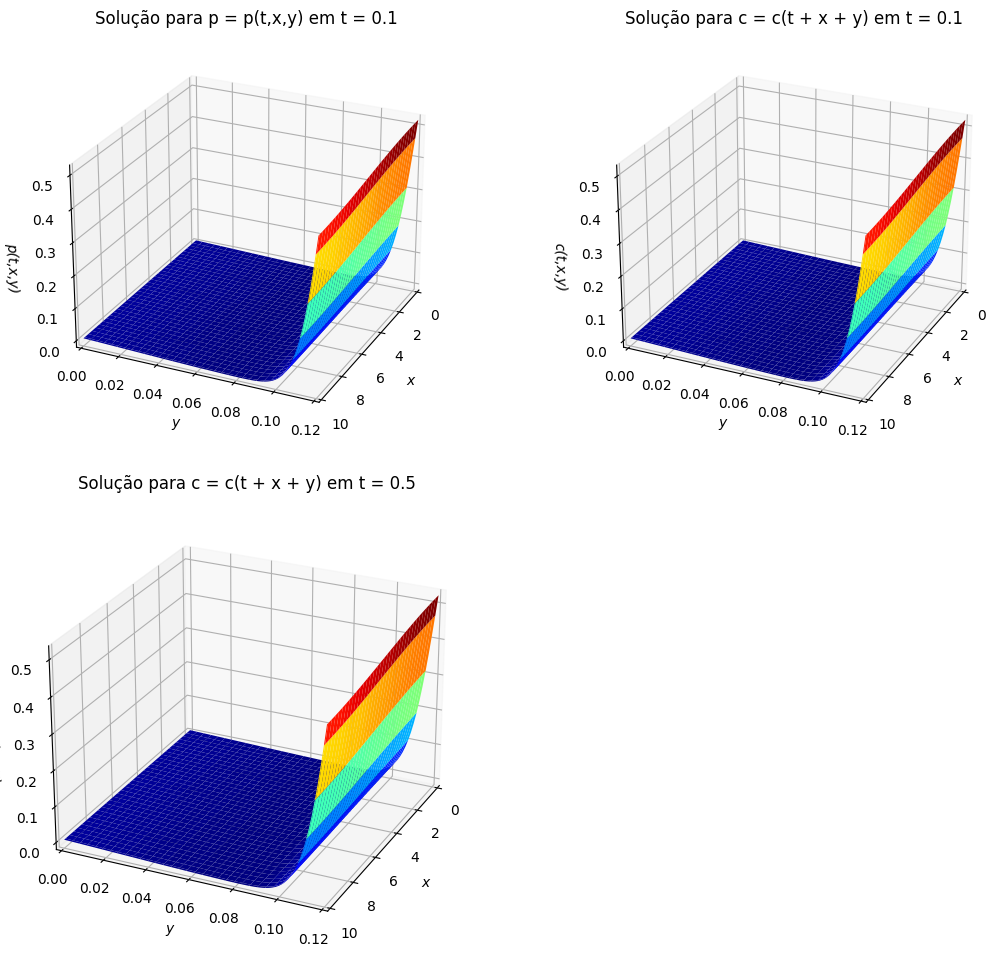

In [73]:
fig  = plt.figure(figsize = (20, 18))
# snapshot 1
ax   = fig.add_subplot(3, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_01[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para p = p(t,x,y) em t = 0.1')

ax   = fig.add_subplot(3, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_05[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.1')
# snapshot 2
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, U_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.5')
'''
# snapshot 3
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1')
'''

In [74]:
tspace = np.linspace(lb[0], ub[0], N + 1)
Tt, Xt, Yt = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([Tt.flatten(),Xt.flatten(), Yt.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

In [75]:
U = upred.numpy().reshape(N+1,N+1,N+1)

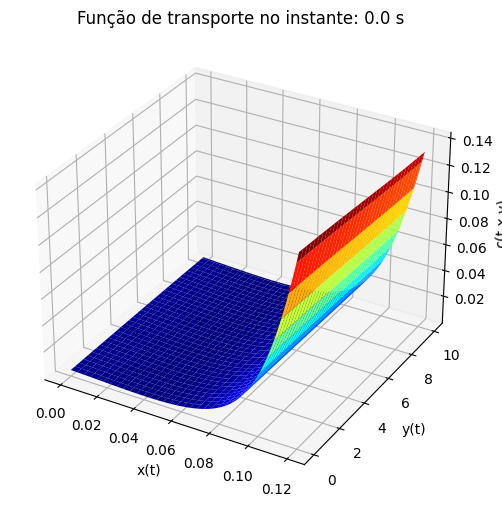

In [76]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

def frame(w):
    ax.clear()

    plt.title("Função de transporte no instante: {:1.4} s".format(tspace[w]))
    ax.set_xlabel('x(t)')
    #ax.set_xlim3d(0,1)
    ax.set_ylabel('y(t)')
    #ax.set_ylim3d(0,1)
    ax.set_zlabel('c(t,x,y)'.format(tspace[w]))
    #ax.set_zlim3d(-val1,val1)

    plot=ax.plot_surface(Yaux, Xaux, U[w], cmap='jet')


    return plot


anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)

anim.save('Função Transporte PINN.gif', writer = "pillow", fps=10 )
HTML(anim.to_html5_video())

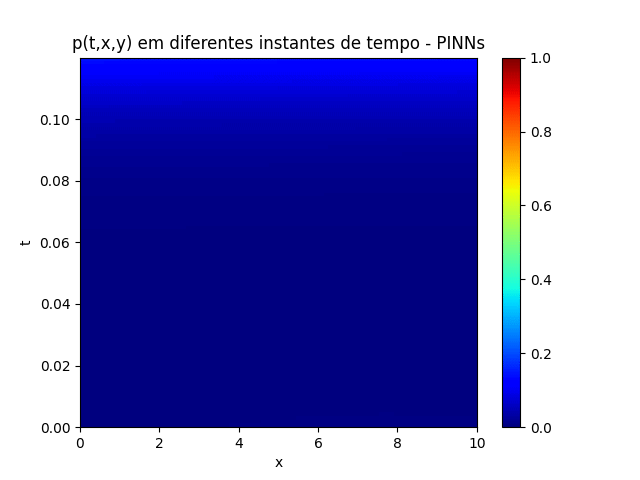

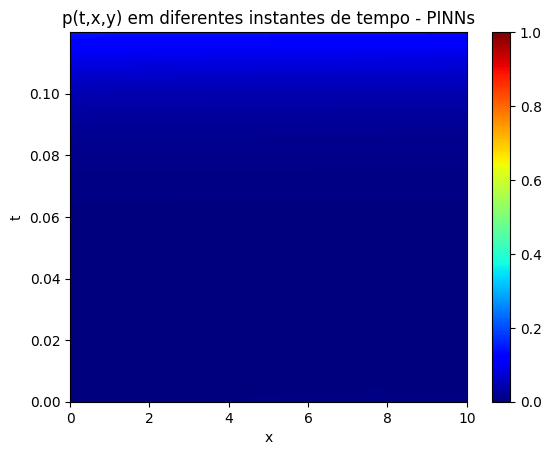

In [77]:
#Plotagem da pinn
def plotheatmap2d(u_k, k):

    plt.clf()
    plt.imshow(u_k, cmap='jet',
              extent=[xspace[0], xspace[-1], yspace[0], yspace[-1]],
              origin='lower', aspect='auto', vmin = 0.0, vmax = 1.0)


    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('p(t,x,y) em diferentes instantes de tempo - PINNs')
    plt.colorbar()
    return plt

def anima(k):
    plotheatmap2d(U[k], k)

animacao = animation.FuncAnimation(plt.figure(), anima, interval=1, frames=100, repeat=False)
animacao.save("testepinn.gif")

display(Image(filename="testepinn.gif"))